# Concatenated Residual Convolutional Network
## Part 1: Demo for deblur ground truth kernel without noise
This is a demo for CRCNet in our paper "Iterative Residual Image Deconvoluiton" (Si-Yao <i>et al.</i>, submitted to AAAI 2019). In this demo, 

The released codes and datasets are only permitted for non-comercial usage. Researchers who use these code or datasets are aksed to cite our paper.

Version 1.0, created by Li Si-Yao
Oct. 2018

In [1]:
import os
import glob
from PIL import Image
import torch
import torchvision
import numpy as np 
import torch.nn as nn
import torch.cuda as cuda
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as T 
import h5py
import math
import argparse
import copy
from CRCNet import CRCNet

import matplotlib.pyplot as plt

In [2]:
# Parameters

# select which kernel (1-10)
kernum = 1

# content loss trade-off
alpha = 5000

# edge loss trade-off
gamma = 100

# noise standard deviation added in training image
nstr = 1e-4

# noise std added into kernel during training
knstr = 0

# initial learning rate
lr = 1e-3

# epochs to train
epoch_num = 20

# where to store your model
get_name = 'truth_kernel_deblur' + '_kernel' + str(kernum) + '_self_trained/'
if not os.path.isdir(get_name):
	os.mkdir(get_name)
file_store = get_name

# training image count 
image_num = 850

# training kernel count
kernel_num = 1

# batch size for training
batch_size = 32

# image patch size for training
patch_size = 35

# kernel size 
kernel_size = None

# input image size to generate patch_size blur by 'valid' convolution  
input_size = None

# iteration per epoch
iteration_num_per_epoch = 1000

# test image path
path = 'data/test_images/'


trans = T.ToTensor()

# prepare global variables
clear_images = None
test_images = None
kernels = None
kernels_test = None

model = CRCNet().cuda()

smoothl1 = nn.SmoothL1Loss()
dtype = cuda.FloatTensor

loss_recorder = []

## Predefined functions
ycbcr2rgb, rgb2ycbcr, generate_blur, psnr.

Note YCbCr used here is kept identical to MATLAB implementation. 

In [3]:
def rgb2ycbcr(rgb):
    m = np.array([[ 65.481, 128.553, 24.966],
                  [-37.797, -74.203, 112],
                  [ 112, -93.786, -18.214]])
    shape = rgb.shape
    if len(shape) == 3:
        rgb = rgb.reshape((shape[0] * shape[1], 3))
    ycbcr = np.dot(rgb, m.transpose() / 255.0)
    ycbcr[:, 0] += 16.0
    ycbcr[:, 1:] += 128.0
    return ycbcr.reshape(shape)


def ycbcr2rgb(ycbcr):
    m = np.array([[ 65.481, 128.553, 24.966],
                  [-37.797, -74.203, 112],
                  [ 112, -93.786, -18.214]])
    shape = ycbcr.shape
    if len(shape) == 3:
        ycbcr = ycbcr.reshape((shape[0] * shape[1], 3))
    rgb = ycbcr
    rgb[:, 0] -= 16.0
    rgb[:, 1:] -= 128.0
    rgb = np.dot(rgb, np.linalg.inv(m.transpose()) * 255.0)
    return rgb.clip(0, 255).reshape(shape)

def generate_blur(x, kernel, nstr=nstr, knstr=knstr, same=True):
    """
    This function generates blurry images from clear ones and corresponding kernels.
    Input:
        x: (N, C, H, W) images C should be 3 here
        kernel: (N, 1, Hk, Wk) kernels
        nstr: noise sigma added to blurry image
        knstr: noise sigma added to kernel
        same: whether convolution keeps result same size as x. If False, result will be with size of (N, C, H-Hk+1, W-Wk+1). 
    """
    N, C, H, W = x.size()
    kernel_size = kernel.size(2)
    
    # add aditional noise with strength knstr
    kernel += Variable(torch.randn(kernel.size()).cuda() * knstr)
        
    # expand the depth-1 kernels to C
    kernel_expanded = kernel
    for n in range(C - 1):
        kernel_expanded = torch.cat([kernel_expanded, kernel], dim=1)

    # convolute each layer
    if same:
        blur = F.conv2d(x.view(1, N*C, H, W), kernel_expanded.view(N*C, 1, kernel_size, kernel_size), padding=kernel_size//2, groups=N*C) 
        blur += Variable(torch.randn(blur.size()).cuda() * nstr) 
        blur = Variable(blur.data.view(N, C, H, W), requires_grad=False)
    
    else:
        blur = F.conv2d(x.view(1, N*C, H, W), kernel_expanded.view(N*C, 1, kernel_size, kernel_size), padding=0, groups=N*C) 
        blur += Variable(torch.randn(blur.size()).cuda() * nstr) 
        blur = Variable(blur.data.view(N, C, patch_size, patch_size), requires_grad=False)

    return blur

log10 = 1 / torch.log(dtype([10])).cpu().numpy()[0]

def psnr(x_hat, x):
    N, C, H, W = x.size()
    loss = 0
    for i in range(N):
        mse = F.mse_loss(255.0*x_hat[i].view(1, C, H, W), 255.0*x[i].view(1, C, H, W))
    
        if mse.data.cpu().numpy() == 0:
            loss += 100
            continue
        print(float(20 * torch.log(255.0 / torch.sqrt(mse)).data.cpu().numpy() *log10))
        loss += 20 * torch.log(255.0 / torch.sqrt(mse)) *log10
    loss /= N
    return loss

## Reading datas
The proposed training image set contains 850 255x255 images, which are contatenated into h5 file "data/sharp_color_image.h5". For training CRCNet, These images are transfered into single Y channel, stored in "data/sharp_gray_image.h".

Ten test images are concluded in "data/test_images/".

Ten proposed kernels are stored in "data/kernel.h".

In [4]:
def read_data():
    # load kernels:
    global clear_images, test_images, kernels, kernels_test
    f = h5py.File('data/kernel.h5','r')
    kernels_numpy = np.array(f['kernel'][kernum + 330 - 1])
    kernels_test = kernels_numpy[None, None, 15:36, 15:36]
    f.close()

    # load images
    f = h5py.File('data/sharp_gray_image.h5','r')
    images_numpy = np.array(f['sharp_gray_image'][:])
    clear_images = images_numpy
    clear_images = clear_images[:]
    f.close()

    # load real (test) kernels
    kernels = kernels_test
    
    # load test images
    i = 0
    test_images = torch.zeros(10, 3, 256, 256).type(torch.FloatTensor)
    for img_name in glob.glob(os.path.join(path, '*.png')):
        img = Image.open(img_name)
        x = trans(img)
        yx = rgb2ycbcr(x.numpy().transpose(1, 2, 0)*255) / 255.0
    
        test_images[i, :, :, :] = torch.from_numpy(yx.transpose(2, 0, 1)[:, :, :])

        i += 1
    test_images = test_images.cpu().numpy()
    
read_data()
kernel_size = kernels.shape[2]
image_size = clear_images.shape[2]
input_size = patch_size + kernel_size - 1

## Visualizing datas

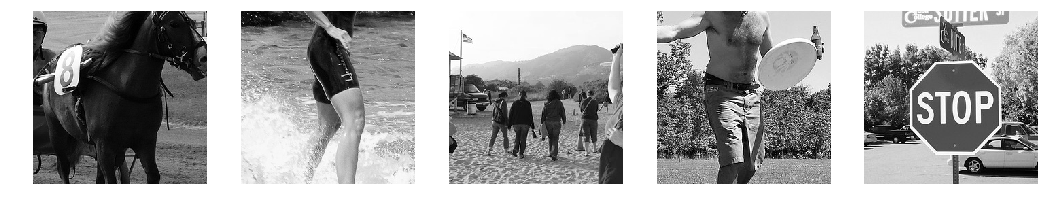

In [5]:
# Visualize samples of clear training images 
fig=plt.figure(figsize=(18, 5))
idxs = np.random.choice(image_num, 5)
imgs = clear_images[idxs]

for i in range(1, 6):    
    fig.add_subplot(1, 5, i)
    plt.imshow(imgs[i - 1][0])
    plt.axis('off')
    plt.gray()
plt.show()

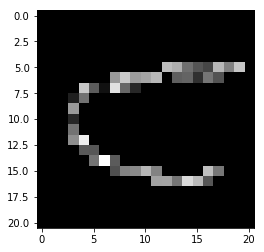

In [6]:
# Visualize kernel
plt.imshow(kernels[0][0])

## Sampling data

In [7]:
def sample(batch_num):
    global image_num
    x_id = np.random.choice(image_num, batch_num)
    xbeg = np.random.choice(image_size - input_size, 1)[0]

    batchx = Variable(torch.from_numpy(clear_images[x_id, :, xbeg : xbeg + input_size , xbeg : xbeg + input_size]).type(dtype), requires_grad=False)
    
    k_id = np.random.choice(range(0, 1), batch_num)
    batchk = Variable(torch.from_numpy(kernels[k_id, :, :, :]).type(dtype), requires_grad=False)

    return batchx, batchk

## Training method
In our work, we take a loss consisting of a content loss and an edge loss:

$\mathcal{L} = \alpha \mathcal{L_c} + \gamma \mathcal{L_e}$, 

where

$\mathcal{L_c}(x, \hat x) = smoothL1(x, \hat x),$

and

$\mathcal{L_e}(x, \hat x) = \|\partial_h{x} - \partial_h{x}\|^2 + \|\partial_v{x} - \partial_v{x}\|^2$.

In [8]:
def alpha_norm(x, xhat, n=2):
	dx = x[:, :, 1:, :] - x[:, :, :-1, :] + 1e-9
	dy = x[:, :, :, 1:] - x[:, :, :, :-1] + 1e-9
	dxh = xhat[:, :, 1:, :] - xhat[:, :, :-1, :] + 1e-9
	dyh = xhat[:, :, :, 1:] - xhat[:, :, :, :-1] + 1e-9
	return ((dx-dxh+1e-9).norm(n) + (dyh-dy + 1e-9).norm(n) + 1e-9)

def train(x, y, optimizer, print_loss=False):

	x_hat = model(y)

	loss = alpha * smoothl1(x_hat, x) + gamma * alpha_norm(x_hat, x, 2)

	optimizer.zero_grad()
	loss.backward()

	if print_loss:
		print('Loss = %f' % loss.data.cpu().numpy())
	loss_recorder.append(float(loss.data.cpu().numpy()))
	
	loss = None
	optimizer.step()
	optimizer.zero_grad()

## Let's start to train!
Training process takes about 10+ mins in our tests.

In [9]:
for epoch in range(0, epoch_num):
	print('Epoch %d' % epoch)
	# Initialize optimizers here
	optimizer = torch.optim.Adam([{'params' : model.parameters()}], lr=lr)
    
	for i in range(iteration_num_per_epoch):
		if False:
			print('Epoch %d Iteration %d' % (epoch, i))
		batchx, batchk = sample(batch_size)
		
		batchy = generate_blur(batchx, batchk, nstr, knstr, False)
		hlfsz = kernel_size // 2 

		batchx = batchx[:, :, hlfsz : patch_size + hlfsz, hlfsz: patch_size + hlfsz]

		if i % 100 ==0:
			print_loss = True
		else:
			print_loss = False
				
		train(batchx, batchy, optimizer, print_loss)

			
		batchx = None
		batchk = None
		batchy = None
		
	# Update learning rate
	lr *= 0.8
torch.save(model.state_dict(), file_store + 'model_self_trained' + '.pkl')

Epoch 0
Loss = 4621.363281
Loss = 2809.369873
Loss = 3213.728516
Loss = 4193.272949
Loss = 3108.883057
Loss = 2542.443604
Loss = 2562.531006
Loss = 3119.640137
Loss = 2487.450439
Loss = 2448.350098
Epoch 1
Loss = 2636.163574
Loss = 2317.076660
Loss = 1938.777100
Loss = 2603.332764
Loss = 2217.060791
Loss = 2130.175537
Loss = 2091.958008
Loss = 2303.936279
Loss = 2774.897705
Loss = 2236.839844
Epoch 2
Loss = 2200.676025
Loss = 2749.999023
Loss = 2133.299316
Loss = 2406.937988
Loss = 1758.318237
Loss = 2076.756104
Loss = 2074.269043
Loss = 2403.623291
Loss = 2134.715820
Loss = 2401.748047
Epoch 3
Loss = 1829.287964
Loss = 1963.458984
Loss = 2087.026611
Loss = 1950.840942
Loss = 2087.870605
Loss = 2861.962402
Loss = 2025.537109
Loss = 2318.428467
Loss = 2312.923340
Loss = 2158.217773
Epoch 4
Loss = 2253.303467
Loss = 2030.363647
Loss = 1779.744385
Loss = 1868.975952
Loss = 1918.307861
Loss = 2295.986816
Loss = 2398.710205
Loss = 2421.331299
Loss = 2374.885986
Loss = 2453.836914
Epoch 5
Lo

## Test using trained model

In [10]:
x_val = test_images[0: 10, 0:1 ,:, :]
k_id = np.random.choice(1, 10)
k_val = kernels_test[k_id, :, :, :]
k_id = torch.from_numpy(k_id).type(torch.cuda.LongTensor)
x_val = Variable(torch.from_numpy(x_val).type(dtype), volatile=True, requires_grad=False)
k_val = Variable(torch.from_numpy(k_val).type(dtype), volatile=True, requires_grad=False)

# generate tested blur
y_val = generate_blur(x_val, k_val, 0, 0)
x_hat = model(y_val)
    
result = copy.deepcopy(test_images[0:10])
result[:, 0:1, :, :] = x_hat.data.cpu().numpy()
blur = copy.deepcopy(test_images[0:10])
blur[:, 0:1, :, :] = y_val.data.cpu().numpy()

result = result.transpose(0, 2, 3, 1)
blur = blur.transpose(0, 2, 3, 1)

for n in range(10):
	result[n] = ycbcr2rgb(result[n] * 255.0) / 255.0
for n in range(10):
	blur[n] = ycbcr2rgb(blur[n] * 255.0) / 255.0

/home/likewise-open/SENSETIME/lisiyao1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/home/likewise-open/SENSETIME/lisiyao1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


## Visualizing deblur results

Blur 1-5:


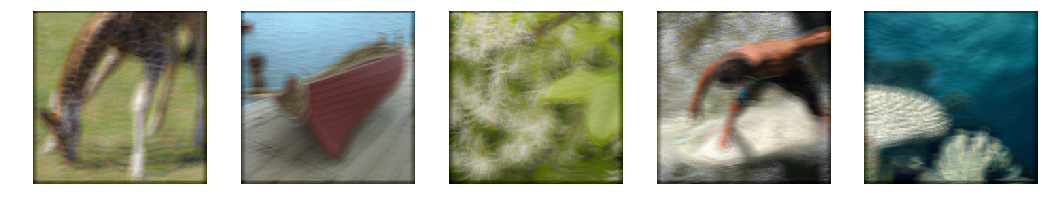

Deblur 1-5:


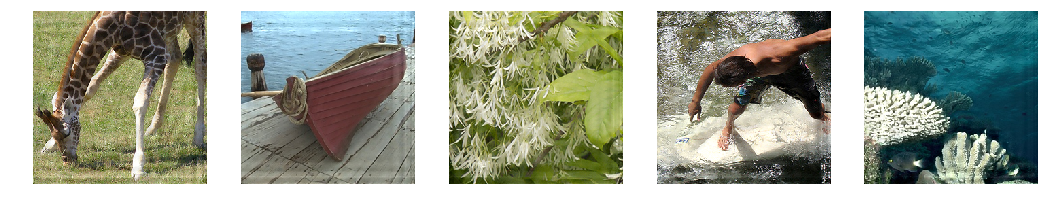

Blur 6-10:


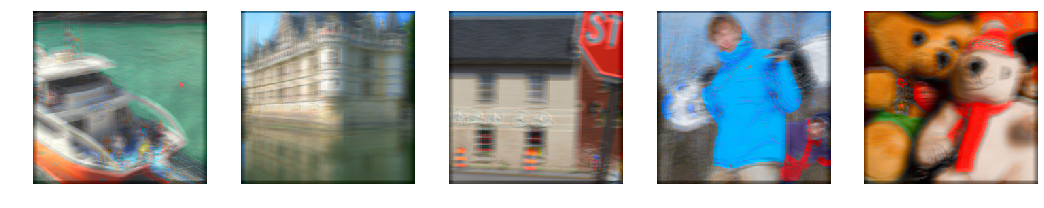

Deblur 6-10:


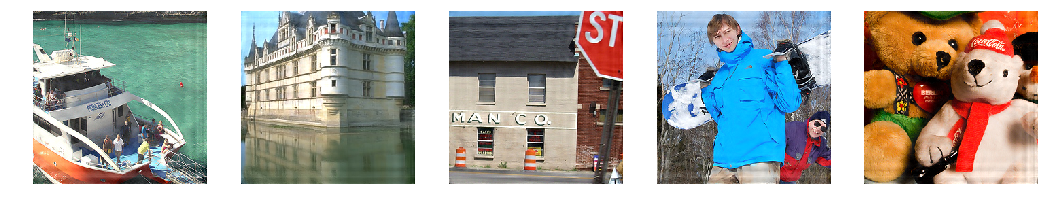

In [13]:
print('Blur 1-5:')
fig1=plt.figure(figsize=(18, 5))

for i in range(1, 6):    
    fig1.add_subplot(1, 5, i)
    plt.imshow(blur[i - 1])
    plt.axis('off')
plt.show()

print('Deblur 1-5:')
fig2=plt.figure(figsize=(18, 5))
for i in range(1, 6):    
    fig2.add_subplot(1, 5, i)
    plt.imshow(result[i - 1])
    plt.axis('off')
plt.show()

print('Blur 6-10:')
fig=plt.figure(figsize=(18, 5))
for i in range(1, 6):    
    fig.add_subplot(1, 5, i)
    plt.imshow(blur[i+5 - 1])
    plt.axis('off')
plt.show()

print('Deblur 6-10:')
fig=plt.figure(figsize=(18, 5))
for i in range(1, 6):    
    fig.add_subplot(1, 5, i)
    plt.imshow(result[i+5 - 1])
    plt.axis('off')
plt.show()